In [30]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [31]:
# 2. Load Dataset
file_path = '/content/weather_data.csv'
data = pd.read_csv(file_path)

In [32]:
# 3. Initial Data Inspection
print(data.head())
print(data.info())
print(data.describe())

         date  avg_temperature   humidity  avg_wind_speed rain_or_not  \
0  2023-01-01        23.745401  46.140905        7.845981        Rain   
1  2023-01-02        30.030503  59.876587        5.382457        Rain   
2  2023-01-03        28.365224  51.464618       13.158008        Rain   
3  2023-01-04        27.550929  53.103799        5.886677        Rain   
4  2023-01-05        23.639303  57.826186       12.248992        Rain   

   cloud_cover     pressure  
0    20.851051   992.965681  
1    93.059521  1037.273025  
2    11.636640  1034.193357  
3    81.744971   968.610142  
4    38.062329  1030.264331  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             311 non-null    object 
 1   avg_temperature  296 non-null    float64
 2   humidity         296 non-null    float64
 3   avg_wind_speed   296 non-null    float64
 

In [33]:
# 4. Handling Missing Values
# Check for missing values
print("Missing values before cleaning:\n", data.isnull().sum())

# Inspect unique values in problematic columns
print("Unique values in avg_temperature column:", data['avg_temperature'].unique())
print("Unique values in humidity column:", data['humidity'].unique())
print("Unique values in avg_wind_speed column:", data['avg_wind_speed'].unique())

# Clean potential non-numeric values
for column in ['avg_temperature', 'humidity', 'avg_wind_speed']:
    data[column] = pd.to_numeric(data[column], errors='coerce')
    if data[column].isnull().all():
        print(f"Warning: Column '{column}' contains only non-numeric values.")
        data[column].fillna(0, inplace=True)  # Fill with 0 if all values are NaN
    else:
        imputer = SimpleImputer(strategy='mean')
        data[column] = imputer.fit_transform(data[[column]])

# For categorical columns, fill missing values with mode if any
if data['rain_or_not'].isnull().all():
    data['rain_or_not'].fillna(0, inplace=True)
else:
    data['rain_or_not'].fillna(data['rain_or_not'].mode()[0], inplace=True)

# Drop rows with NaN values in essential columns
data.dropna(subset=['avg_temperature', 'humidity', 'avg_wind_speed', 'rain_or_not'], inplace=True)

# Verify dataset is not empty after cleaning
print("Data shape after cleaning:", data.shape)
if data.shape[0] == 0:
    raise ValueError("No data left after cleaning. Please check the preprocessing steps.")


Missing values before cleaning:
 date                0
avg_temperature    15
humidity           15
avg_wind_speed     15
rain_or_not         0
cloud_cover        15
pressure            0
dtype: int64
Unique values in avg_temperature column: [23.74540119 30.03050263 28.36522405 27.55092949 23.63930331 24.14813565
 23.67100607 32.24544095 30.07851655 31.62063078 25.20584494 35.
         nan 28.41659502 28.50955574 33.01902393 32.40962013 31.29899708
 34.77878299 30.30500385 32.05690106 32.9994227  34.07126501 31.77821383
 30.45079947 31.69153658 30.59573488 32.55670285 30.31252541 33.31159018
 29.88063639 33.33847478 28.43405515 33.69629066 29.80841682 31.34495532
 27.29493491 34.69584628 32.29123323 32.531953   29.06916973 31.8069328
 22.96404193 21.49755752 23.77666287 23.8867729  22.19013076 27.24209046
 22.00318862 20.73022819 22.83877038 18.31907231 24.43829031 16.67814001
 25.32896437 22.72244769 15.         21.86141037 20.37726737 20.21900387
 20.28125521 15.49448734 19.97078022 1

<ipython-input-33-99457e04b424>:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['rain_or_not'].fillna(data['rain_or_not'].mode()[0], inplace=True)


In [34]:
# 5. Data Formatting and Encoding
# Convert date to datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Handle incorrect entries and drop rows with invalid dates
data = data.dropna(subset=['date'])




Numeric columns used for correlation matrix: Index(['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover',
       'pressure'],
      dtype='object')


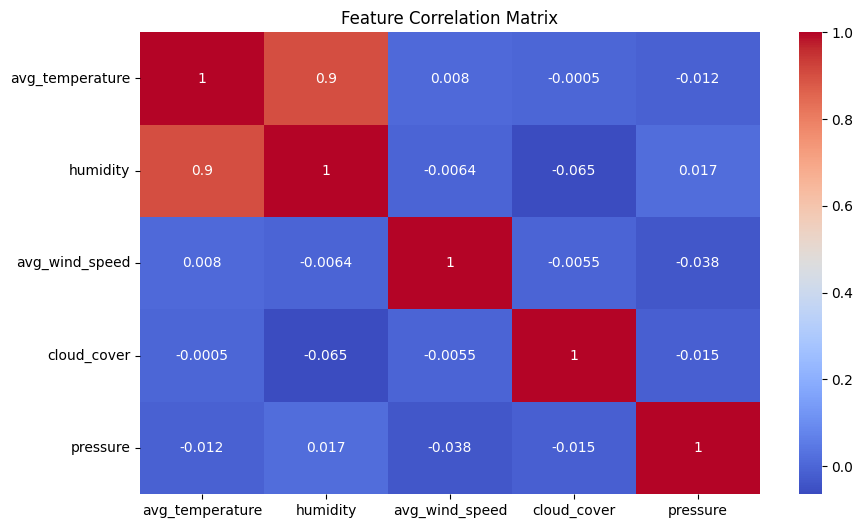

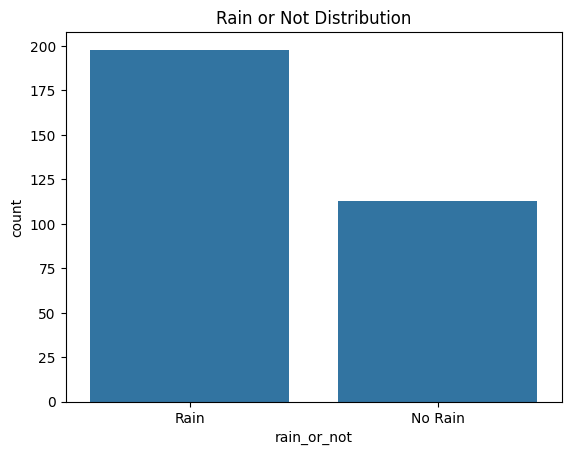

In [36]:
# 6. Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
# Select only numeric columns for correlation matrix
data_numeric = data.select_dtypes(include=[np.number])
print("Numeric columns used for correlation matrix:", data_numeric.columns)
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Distribution of Rain and No Rain
sns.countplot(x='rain_or_not', data=data)
plt.title('Rain or Not Distribution')
plt.show()




In [37]:
# 7. Feature and Label Splitting
X = data[['avg_temperature', 'humidity', 'avg_wind_speed']]
y = data['rain_or_not']

# Ensure sufficient samples are available for model training
if len(X) < 2:
    raise ValueError("Insufficient data for training and testing.")

In [38]:
# 8. Data Splitting for Training and Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# 9. Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
# 10. Model Training (Random Forest)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [42]:
# 11. Predictions and Evaluation
y_pred = model.predict(X_test)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))
print('Accuracy Score:', accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[ 6 16]
 [13 28]]
Classification Report:
               precision    recall  f1-score   support

     No Rain       0.32      0.27      0.29        22
        Rain       0.64      0.68      0.66        41

    accuracy                           0.54        63
   macro avg       0.48      0.48      0.48        63
weighted avg       0.52      0.54      0.53        63

Accuracy Score: 0.5396825396825397


In [43]:
# 12. Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print('Best Parameters:', grid_search.best_params_)

Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [44]:
# 13. Final Model with Best Parameters
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print('Optimized Accuracy Score:', accuracy_score(y_test, y_pred_best))

Optimized Accuracy Score: 0.6031746031746031


In [45]:
# 14. Probability Prediction for Future 21 Days
future_predictions = best_model.predict_proba(X_test)[:21]
print('Future 21-Day Rain Probability:\n', future_predictions)

Future 21-Day Rain Probability:
 [[0.28051587 0.71948413]
 [0.12906746 0.87093254]
 [0.4506456  0.5493544 ]
 [0.18880952 0.81119048]
 [0.05791667 0.94208333]
 [0.80026984 0.19973016]
 [0.55057143 0.44942857]
 [0.69306746 0.30693254]
 [0.45651587 0.54348413]
 [0.30996032 0.69003968]
 [0.53484524 0.46515476]
 [0.0712619  0.9287381 ]
 [0.41976587 0.58023413]
 [0.48903968 0.51096032]
 [0.45423016 0.54576984]
 [0.27165873 0.72834127]
 [0.2472381  0.7527619 ]
 [0.14809921 0.85190079]
 [0.23604762 0.76395238]
 [0.50613584 0.49386416]
 [0.6472381  0.3527619 ]]
